#Proyecto Procesamiento de Lenguaje Natural :

#Clasificacion de generos musicales colombianos por medio del analisis de caracteristicas de sus letras

##Sergio Steven Lopez Martinez

##Imports de librerias a utilizar

In [ ]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import librosa as lb
import numpy as np
import sklearn
import os
from PIL import Image
from textblob import TextBlob
import pathlib
import csv
import pylab as pl
import nltk
import re, string, unicodedata
from unicodedata import normalize
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

##Carga del dataset de letras de canciones de los 6 generos musicales(Cumbia, Carranga, Pasillo, Bambuco, Vallenato, Joropo) hechas manualmente

In [ ]:
#!wget -O Canciones.zip "https://drive.google.com/uc?export=download&id=1tf0p96LDQvl5VSagIq8lVRcgLXjDpxqq"
#!unzip Canciones.zip
!wget -O Canciones2.zip "https://drive.google.com/uc?export=download&id=1qKRg_UvylgVbo00fCSS6HhRWhgetsTYb"
!unzip Canciones2.zip

--2019-07-17 12:40:55--  https://drive.google.com/uc?export=download&id=1qKRg_UvylgVbo00fCSS6HhRWhgetsTYb
Resolving drive.google.com (drive.google.com)... 74.125.141.101, 74.125.141.139, 74.125.141.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lu95lif39m0941dkfnknivp0oq1je18g/1563364800000/10519510251368043159/*/1qKRg_UvylgVbo00fCSS6HhRWhgetsTYb?e=download [following]
--2019-07-17 12:40:56--  https://doc-0g-40-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/lu95lif39m0941dkfnknivp0oq1je18g/1563364800000/10519510251368043159/*/1qKRg_UvylgVbo00fCSS6HhRWhgetsTYb?e=download
Resolving doc-0g-40-docs.googleusercontent.com (doc-0g-40-docs.googleusercontent.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to doc-0g-40-docs.googleusercontent.com (doc-0g

In [ ]:
!ls -la Canciones

total 736
drwxr-xr-x 2 root root 12288 Jul 16 10:34 .
drwxr-xr-x 1 root root  4096 Jul 17 12:40 ..
-rw-r--r-- 1 root root  1173 Jul 16 18:45 Bambuco01.txt
-rw-r--r-- 1 root root   806 Jul 16 18:41 Bambuco02.txt
-rw-r--r-- 1 root root   743 Jul 16 18:46 Bambuco03.txt
-rw-r--r-- 1 root root   905 Jul 16 18:42 Bambuco04.txt
-rw-r--r-- 1 root root   961 Jul 14 21:11 Bambuco05.txt
-rw-r--r-- 1 root root  1037 Jul 14 21:11 Bambuco06.txt
-rw-r--r-- 1 root root   656 Jul 14 21:11 Bambuco07.txt
-rw-r--r-- 1 root root   610 Jul 14 21:11 Bambuco08.txt
-rw-r--r-- 1 root root   721 Jul 14 21:11 Bambuco09.txt
-rw-r--r-- 1 root root   730 Jul 14 14:48 Bambuco10.txt
-rw-r--r-- 1 root root   501 Jul 16 07:43 Bambuco11.txt
-rw-r--r-- 1 root root   458 Jul 16 07:44 Bambuco12.txt
-rw-r--r-- 1 root root  1062 Jul 16 07:44 Bambuco13.txt
-rw-r--r-- 1 root root   938 Jul 16 07:45 Bambuco14.txt
-rw-r--r-- 1 root root   565 Jul 16 07:55 Bambuco15.txt
-rw-r--r-- 1 root root   732 Jul 16 07:59 Bambuco16.txt
-rw-r

##Funciones de preprocesamiento de los datos(tokenizacion, remover stop words, lematizacion, normalizacion en general)

In [ ]:
def normalize_tildes(string):
    replacements = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for a, b in replacements:
        string = string.replace(a, b).replace(a.upper(), b.upper())
    return string

def remove_non_ascii(words):
    """Remover caracteres que son son ASCII de la lista de palabras tokenizadas"""
    new_words = []
    for word in range(len(words)):
        new_word = unicodedata.normalize('NFD', words[word]).encode('utf-8').decode('ascii', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convierte todos los caracteres a minuscula de una lista de tokens"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remueve la puntuacion de una lista de tokens"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplaza todos los numeros a su representacion textual"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remueve stopwords"""
    new_words = []
    for word in words:
      if len(word)>3:
        new_words.append(word)
      if word not in stopwords.words('spanish'):
        new_words.append(word)
    return new_words

def stem_words(words):
    """Stemmming de palabras de una lista de tokens"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """lemmatizacion a los verbos de una lista de tokens"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas
  
def stem(words):
    stems = stem_words(words)
    return stems
  
def lemmatize(words):
    lemmas = lemmatize_verbs(words)
    return lemmas
  
def normalize(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = lemmatize(words)
    return words
  
def normalizeStem(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    words = stem(words)
    return words

##Extraccion de caracteristicas para el modelo

In [ ]:
Cancion_path = 'Canciones/Bambuco02.txt'

###Cantidad de lineas de un documento

In [ ]:
archivo = open(Cancion_path, "r", encoding='latin-1')

In [ ]:
lineas = len(archivo.readlines())
lineas

29

###Tokenizamos el documento para extraer mas caracteristicas

In [ ]:
archivo = open(Cancion_path, "r", encoding='latin-1')

In [ ]:
words = nltk.word_tokenize(archivo.read())
print(words)

['Adoro', 'Nina', 'tus', 'Ojos', 'Adoro', 'nina', 'tus', 'ojos', 'porque', 'retratan', 'los', 'cielos', '.', 'Me', 'gustan', 'tus', 'labios', 'rojos', 'porque', 'a', 'la', 'miel', 'le', 'dan', 'celos', '.', 'me', 'gustan', 'tus', 'labios', 'rojos', 'porque', 'a', 'la', 'miel', 'le', 'dan', 'celos', '.', 'Adoro', 'nina', 'tus', 'ojos', 'porque', 'retratan', 'los', 'cielos', '.', 'Me', 'dan', 'envidia', 'los', 'cielos', 'porque', 'viven', 'en', 'tus', 'ojos', 'y', 'la', 'miel', 'me', 'causa', 'celos', 'porque', 'esta', 'en', 'tus', 'labios', 'rojos', '.', 'Y', 'la', 'miel', 'me', 'causa', 'celos', 'porque', 'esta', 'en', 'tus', 'labios', 'rojos', '.', 'Ante', 'el', 'cielo', 'de', 'tus', 'ojos', 'y', 'el', 'misterio', 'de', 'tus', 'labios', 'esta', 'la', 'ciencia', 'de', 'hinojos', 'y', 'estan', 'absortos', 'los', 'sabios', '.', 'esta', 'la', 'ciencia', 'de', 'hinojos', 'y', 'estan', 'absortos', 'los', 'sabios', '.', 'Ante', 'el', 'cielo', 'de', 'tus', 'ojos', 'y', 'el', 'misterio', 'de',

###Numero de caracteres de un documento

In [ ]:
archivo = open(Cancion_path, "r", encoding='latin-1')

In [ ]:
def numCaracteres(words):
  num = 0
  for word in words:
    num += len(word)
  return num

In [ ]:
numCaracteres(words)

622

###Numero de palabras del documento

In [ ]:
words = remove_non_ascii(words)
words = remove_punctuation(words)
print(len(words))

157


###Numero de palabras unicas del documento

In [ ]:
diccionario = dict.fromkeys(words).keys()
len(diccionario)

50

In [ ]:
archivo = open(Cancion_path, "r", encoding='latin-1')

In [ ]:
words = nltk.word_tokenize(archivo.read())
words = normalize(words)
print(words)

['adoro', 'adoro', 'nina', 'nina', 'ojos', 'ojos', 'adoro', 'adoro', 'nina', 'nina', 'ojos', 'ojos', 'porque', 'retratan', 'retratan', 'cielos', 'cielos', 'gustan', 'gustan', 'labios', 'labios', 'rojos', 'rojos', 'porque', 'miel', 'miel', 'dan', 'celos', 'celos', 'gustan', 'gustan', 'labios', 'labios', 'rojos', 'rojos', 'porque', 'miel', 'miel', 'dan', 'celos', 'celos', 'adoro', 'adoro', 'nina', 'nina', 'ojos', 'ojos', 'porque', 'retratan', 'retratan', 'cielos', 'cielos', 'dan', 'envidia', 'envidia', 'cielos', 'cielos', 'porque', 'viven', 'viven', 'ojos', 'ojos', 'miel', 'miel', 'causa', 'causa', 'celos', 'celos', 'porque', 'esta', 'labios', 'labios', 'rojos', 'rojos', 'miel', 'miel', 'causa', 'causa', 'celos', 'celos', 'porque', 'esta', 'labios', 'labios', 'rojos', 'rojos', 'ante', 'cielo', 'cielo', 'ojos', 'ojos', 'misterio', 'misterio', 'labios', 'labios', 'esta', 'ciencia', 'ciencia', 'hinojos', 'hinojos', 'estan', 'estan', 'absortos', 'absortos', 'sabios', 'sabios', 'esta', 'cienc

In [ ]:
len(words)

156

In [ ]:
diccionario = dict.fromkeys(words).keys()
len(diccionario)

30

###Analisis de sentimiento

In [ ]:
archivo = open(Cancion_path, "r", encoding='latin-1')

In [ ]:
from textblob import TextBlob

In [ ]:
analysis = TextBlob(archivo.read())
print(analysis.sentiment)
traduccion = analysis.translate(from_lang='es',to='en')
print(traduccion.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.33356643356643356, subjectivity=0.5230769230769231)


In [ ]:
print(traduccion.sentiment.polarity)

0.33356643356643356


In [ ]:
print(traduccion)

I love Nina your Eyes
I love your eyes
because they portray the heavens.
I like your red lips
because they give jealousy to honey.
I like your red lips
because they give jealousy to honey.
I love your eyes
because they portray the heavens.
I envy the heavens
because they live in your eyes
and honey causes me jealousy
because it is on your red lips.
And honey causes jealousy
because it is on your red lips.
Before the sky of your eyes
and the mystery of your lips
is the fennel science
and the wise are absorbed.
is the fennel science
and the wise are absorbed.
Before the sky of your eyes
and the mystery of your lips.
That's why when I see myself on fennels
I die, the wise say
If your eyes do not look at me,
if your lips do not kiss me.
If your eyes do not look at me,
if your lips do not kiss me.


##Creando el dataset con caracteristicas

In [ ]:
header = 'filename PalabrasPorLinea PalabrasUnicasPorLinea RazonPalabrasUnicas CaracteresPorPalabra Sentimiento'
header += ' label'
header = header.split()

In [ ]:
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
    
genres = 'bambuco carranga cumbia joropo pasillo vallenato'.split()

for filename in os.listdir(f'./Canciones/'):
  file = open('data.csv', 'a', newline='')
  archivo = open(f'./Canciones/{filename}', "r", encoding='latin-1')
  lineas = len(archivo.readline())
  archivo = open(f'./Canciones/{filename}', "r", encoding='latin-1')
  palabras = nltk.word_tokenize(archivo.read())
  palabras = remove_non_ascii(palabras)
  palabras = remove_punctuation(palabras)
  palabrasNum = len(palabras)
  caracteres = numCaracteres(palabras)
  diccionario = dict.fromkeys(words).keys()
  archivo = open(f'./Canciones/{filename}', "r", encoding='latin-1')
  analysis = TextBlob(archivo.read())
  traduccion = analysis.translate(from_lang='es',to='en')
  palabrasU = len(diccionario)
  PalabrasXLinea = palabrasNum/lineas
  PalabrasUXLinea = palabrasU/lineas
  RazonPalabrasU = palabrasU/palabrasNum
  CaracteresXPalabra = caracteres/palabrasNum
  ASentimiento = traduccion.sentiment.polarity
  to_append = f'{filename} {PalabrasXLinea} {PalabrasUXLinea} {RazonPalabrasU} {CaracteresXPalabra} {ASentimiento} {filename[:-6].replace(".", "")}'
  with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())


In [ ]:
data = pd.read_csv('data.csv', error_bad_lines=False)
data

,filename,PalabrasPorLinea,PalabrasUnicasPorLinea,RazonPalabrasUnicas,CaracteresPorPalabra,Sentimiento,label
0,Vallenato18.txt,15.235294,1.764706,0.115830,4.262548,0.314756,Vallenato
1,Joropo14.txt,8.785714,2.142857,0.243902,4.341463,0.273661,Joropo
2,Carranga14.txt,7.105263,1.578947,0.222222,4.437037,0.287798,Carranga
3,Cumbia30.txt,22.833333,1.666667,0.072993,3.362530,-0.152976,Cumbia
4,Cumbia14.txt,7.666667,2.500000,0.326087,4.619565,-0.141944,Cumbia
5,Carranga23.txt,2.887097,0.483871,0.167598,4.240223,-0.194345,Carranga
6,Vallenato06.txt,5.636364,0.681818,0.120968,3.927419,0.298082,Vallenato
7,Vallenato17.txt,40.500000,7.500000,0.185185,3.543210,0.315000,Vallenato
8,Joropo25.txt,16.454545,2.727273,0.165746,3.889503,0.442857,Joropo
9,Bambuco16.txt,7.411765,1.764706,0.238095,4.412698,0.220000,Bambuco


##Graficas de sentimiento por clase vs general

###Joropo

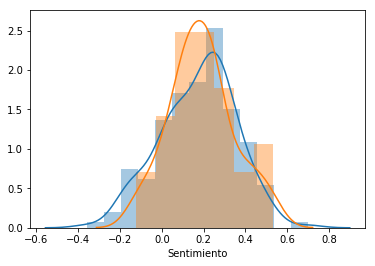

In [ ]:
import seaborn as sns  
import matplotlib.pyplot as plt  
%matplotlib inline
data_filter = data[data['label'] == "Joropo"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

###Cumbia

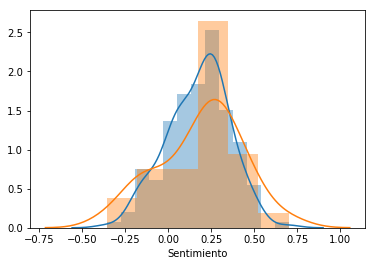

In [ ]:
data_filter = data[data['label'] == "Cumbia"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

###Carranga

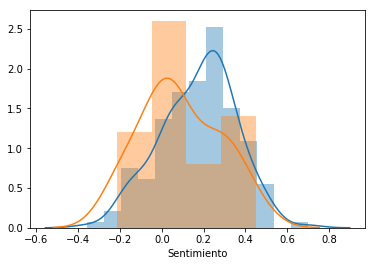

In [ ]:
data_filter = data[data['label'] == "Carranga"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

###Vallenato

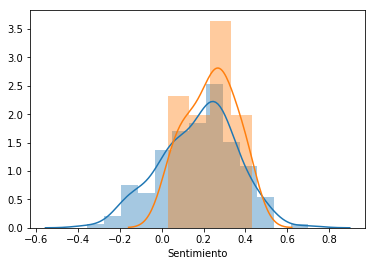

In [ ]:
data_filter = data[data['label'] == "Vallenato"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

###Pasillo

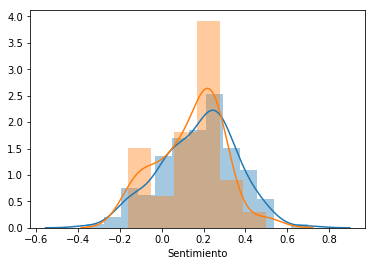

In [ ]:
data_filter = data[data['label'] == "Pasillo"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

###Bambuco

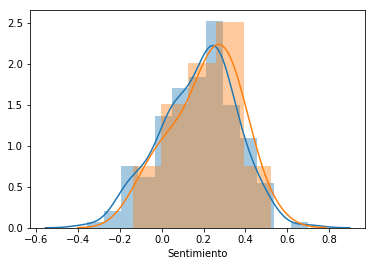

In [ ]:
data_filter = data[data['label'] == "Bambuco"]
sns.distplot(data['Sentimiento'])  
sns.distplot(data_filter['Sentimiento'])  

##Razon de Palabras unicas en las letras de cada genero vs general

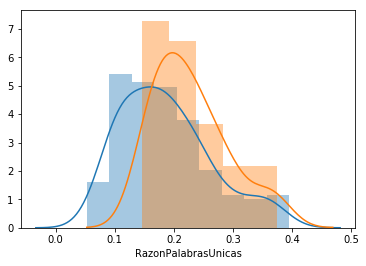

In [ ]:
data_filter = data[data['label'] == "Bambuco"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

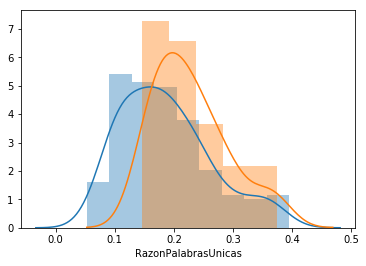

In [ ]:
data_filter = data[data['label'] == "Bambuco"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

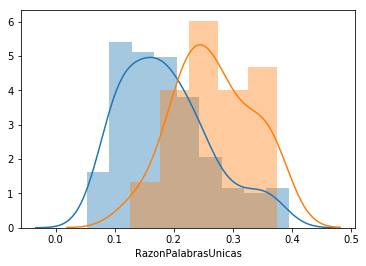

In [ ]:
data_filter = data[data['label'] == "Pasillo"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

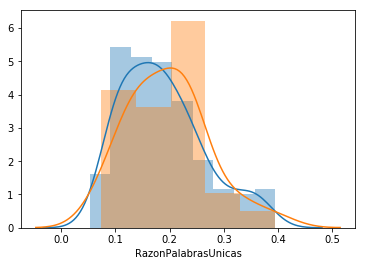

In [ ]:
data_filter = data[data['label'] == "Cumbia"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

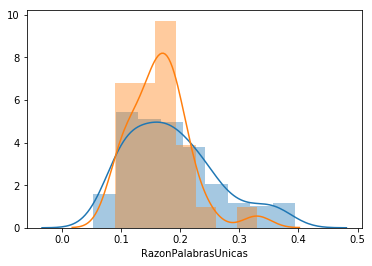

In [ ]:
data_filter = data[data['label'] == "Carranga"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

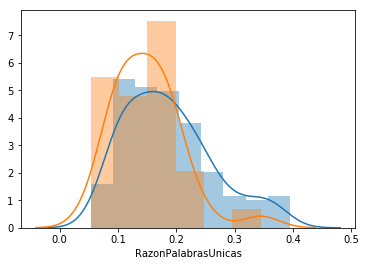

In [ ]:
data_filter = data[data['label'] == "Joropo"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

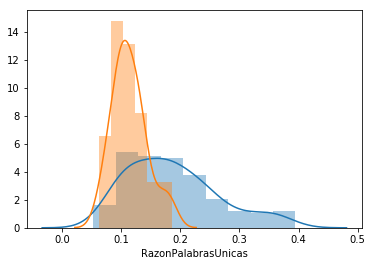

In [ ]:
data_filter = data[data['label'] == "Vallenato"]
sns.distplot(data['RazonPalabrasUnicas'])  
sns.distplot(data_filter['RazonPalabrasUnicas'])  

In [ ]:
len(data)

180

In [ ]:
data.shape

(180, 7)

###Preparando datos para entrenamiento, codificando las etiquetas 

In [ ]:
data = data.drop(['filename'],axis=1)

In [ ]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)

In [ ]:
data = data.drop(['label'],axis=1)

In [ ]:
data

,PalabrasPorLinea,PalabrasUnicasPorLinea,RazonPalabrasUnicas,CaracteresPorPalabra,Sentimiento
0,15.235294,1.764706,0.115830,4.262548,0.314756
1,8.785714,2.142857,0.243902,4.341463,0.273661
2,7.105263,1.578947,0.222222,4.437037,0.287798
3,22.833333,1.666667,0.072993,3.362530,-0.152976
4,7.666667,2.500000,0.326087,4.619565,-0.141944
5,2.887097,0.483871,0.167598,4.240223,-0.194345
6,5.636364,0.681818,0.120968,3.927419,0.298082
7,40.500000,7.500000,0.185185,3.543210,0.315000
8,16.454545,2.727273,0.165746,3.889503,0.442857
9,7.411765,1.764706,0.238095,4.412698,0.220000


In [ ]:
dataNB = data.drop(['Sentimiento'],axis=1)

In [ ]:
data.shape

(180, 5)

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
data= X

In [ ]:
data.shape

(180, 4)

In [ ]:
y

array([5, 3, 1, 2, 2, 1, 5, 5, 3, 0, 1, 1, 2, 2, 0, 1, 2, 0, 0, 0, 3, 0,
       1, 3, 4, 0, 2, 5, 1, 1, 2, 4, 3, 2, 4, 0, 1, 5, 4, 2, 2, 3, 4, 1,
       0, 3, 1, 1, 1, 0, 0, 3, 0, 0, 3, 3, 1, 1, 4, 2, 3, 0, 3, 0, 4, 0,
       5, 5, 5, 5, 1, 1, 5, 5, 3, 4, 1, 4, 4, 2, 2, 3, 2, 2, 5, 2, 4, 1,
       3, 5, 2, 0, 4, 3, 4, 3, 1, 5, 2, 4, 1, 3, 3, 2, 4, 5, 5, 4, 4, 1,
       2, 4, 3, 1, 3, 5, 2, 2, 3, 0, 0, 0, 3, 3, 4, 2, 3, 4, 4, 1, 1, 1,
       2, 4, 1, 2, 5, 2, 5, 1, 4, 0, 5, 0, 0, 0, 2, 0, 4, 5, 4, 3, 2, 4,
       5, 5, 5, 5, 3, 3, 0, 4, 1, 3, 4, 0, 0, 0, 5, 0, 4, 1, 2, 5, 5, 3,
       4, 5, 5, 2])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( data, y, 
                                                             test_size=0.2, 
                                                             random_state=1234, 
                                                             stratify=y
                                                            )

partial_x_train, x_val, partial_y_train, y_val = train_test_split( X_train, y_train, 
                                                                                 test_size=0.25,
                                                                                 random_state=1234, 
                                                                                 stratify=y_train
                                                                                )

#Clasificacion

##Clasificacion con Random Forest

###Vamos a realizar una grafica que nos ayude a identificar los errores de entrenamiento y generalizacion para asi escoger el mejor numero de estimadores para entrenar el modelo

In [ ]:
ArrayRF = [2**1, 2**2, 2**3, 2**4, 2**5, 2**6, 2**7, 2**8, 2**9, 2**10, 2**11]

In [ ]:
from sklearn.ensemble import RandomForestClassifier

train_error = []
generalization_error = []

for nn in ArrayRF:
    knn = RandomForestClassifier(n_estimators=nn)
    knn.fit(partial_x_train, partial_y_train)
    train_error.append(1 - knn.score(partial_x_train, partial_y_train))
    generalization_error.append(1 - knn.score(x_val, y_val))

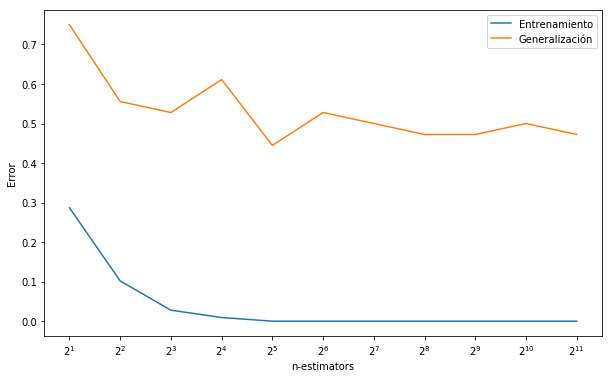

In [ ]:
pl.figure(figsize = (10, 6))

pl.plot(ArrayRF, train_error, label="Entrenamiento")
pl.plot(ArrayRF, generalization_error, label="Generalización")
pl.xscale("log", basex=2) 
pl.xticks(ArrayRF)
pl.xlabel("n-estimators")
pl.ylabel("Error")
# pl.gca().invert_xaxis()
# pl.arrow(13, 0.16, 0, -0.01, head_width=0.2, head_length=0.01, fc='k', ec='k')
# pl.text(15, 0.165, 'Punto de balance')
pl.legend();

###Entrenamiento y evaluacion

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

Random_forest = RandomForestClassifier(n_estimators=2**5)
Random_forest.fit(X_train, y_train)

print('Accuracy: {}'.format(Random_forest.score(X_test, y_test)))
print('Error: {}'.format(1 - Random_forest.score(X_test, y_test)) + '\n')

y_predic = np.array(Random_forest.predict(X_test))

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, y_predic, average=None)))
print('Recall:    {}'.format(metrics.recall_score(y_test, y_predic, average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_predic, average=None))+ '\n')

Accuracy: 0.3055555555555556
Error: 0.6944444444444444

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [0.25       0.22222222 0.33333333 0.25       0.5        0.375     ]
Recall:    [0.16666667 0.33333333 0.16666667 0.33333333 0.33333333 0.5       ]
F_1 score: [0.2        0.26666667 0.22222222 0.28571429 0.4        0.42857143]



In [ ]:
mtrx = confusion_matrix(y_test, y_predic)
df1 = pd.DataFrame(mtrx, index=genres, columns=genres)
print('Matriz de confusión')
print(df1)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          0         2       0       1        3          0
carranga         1         3       0       0        0          2
cumbia           1         1       0       0        0          4
joropo           0         2       0       2        0          2
pasillo          1         1       1       1        2          0
vallenato        0         1       0       2        0          3


##Clasificacion por red neuronal

In [ ]:
from keras import models
from keras import layers

Using TensorFlow backend.


In [ ]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=256,
          validation_data=(x_val, y_val))
results = model.evaluate(X_test, y_test)

W0717 12:41:19.359651 139769465038720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 12:41:19.406837 139769465038720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 12:41:19.413738 139769465038720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 12:41:19.474299 139769465038720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0717 12:41:19.498614 139769465038720 deprecation_wrappe

Train on 108 samples, validate on 36 samples
Epoch 1/20
108/108 [==============================] - 1s 7ms/step - loss: 1.8039 - acc: 0.1667 - val_loss: 1.7748 - val_acc: 0.1667
Epoch 2/20
108/108 [==============================] - 0s 65us/step - loss: 1.7779 - acc: 0.1852 - val_loss: 1.7601 - val_acc: 0.2222
Epoch 3/20
108/108 [==============================] - 0s 63us/step - loss: 1.7518 - acc: 0.2407 - val_loss: 1.7478 - val_acc: 0.2778
Epoch 4/20
108/108 [==============================] - 0s 49us/step - loss: 1.7274 - acc: 0.2870 - val_loss: 1.7355 - val_acc: 0.2778
Epoch 5/20
108/108 [==============================] - 0s 56us/step - loss: 1.7050 - acc: 0.3241 - val_loss: 1.7225 - val_acc: 0.3056
Epoch 6/20
108/108 [==============================] - 0s 69us/step - loss: 1.6847 - acc: 0.3333 - val_loss: 1.7100 - val_acc: 0.3333
Epoch 7/20
108/108 [==============================] - 0s 49us/step - loss: 1.6645 - acc: 0.3889 - val_loss: 1.6972 - val_acc: 0.3611
Epoch 8/20
108/108 [=====

In [ ]:
results

[1.7243643866644964, 0.4166666666666667]

In [ ]:
predictions = model.predict(X_test)
print(predictions)

[[2.49493644e-01 1.25652492e-01 1.01511545e-01 6.95213154e-02
  4.30943340e-01 2.28776690e-02]
 [4.43343520e-02 2.38086451e-02 4.12377231e-02 4.91968453e-01
  3.53476033e-02 3.63303185e-01]
 [2.16850474e-01 2.95246784e-02 1.69965655e-01 6.43962100e-02
  4.89720821e-01 2.95421705e-02]
 [1.46142006e-01 3.47135812e-02 1.16316028e-01 4.65123832e-01
  6.15221150e-02 1.76182389e-01]
 [1.23371415e-01 1.51879579e-01 1.21919081e-01 2.67995834e-01
  1.14532106e-01 2.20302001e-01]
 [4.31873232e-01 6.22437941e-03 3.76014739e-01 4.11294363e-02
  1.37118340e-01 7.63995480e-03]
 [1.48050651e-01 2.33246222e-01 1.78794906e-01 1.92478746e-01
  1.48392990e-01 9.90364701e-02]
 [4.68922369e-02 5.69669940e-02 5.04406169e-02 2.89162993e-01
  6.37800694e-02 4.92757022e-01]
 [1.74830526e-01 1.90553427e-01 1.30356520e-01 1.56128198e-01
  2.31012851e-01 1.17118508e-01]
 [1.32596776e-01 1.55150443e-01 1.31379962e-01 1.97892621e-01
  1.35673389e-01 2.47306794e-01]
 [1.38680920e-01 1.59977660e-01 1.38994798e-01 1.9

In [ ]:
predictions.argmax(axis=1)

array([4, 3, 4, 3, 3, 0, 1, 5, 4, 5, 5, 5, 4, 1, 5, 2, 1, 1, 4, 1, 3, 5,
       4, 5, 5, 4, 3, 1, 1, 5, 3, 3, 3, 1, 1, 3])

In [ ]:
test_loss, test_acc = model.evaluate(X_test,y_test)

print('Accuracy: {}'.format(test_acc))
print('Error: {}'.format(1-test_acc) + '\n')

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, predictions.argmax(axis=1), average=None)))
print('Recall:    {}'.format(metrics.recall_score(y_test, predictions.argmax(axis=1), average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, predictions.argmax(axis=1), average=None))+ '\n')

36/36 [==============================] - 0s 189us/step
Accuracy: 0.4166666666666667
Error: 0.5833333333333333

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [0.         0.44444444 0.         0.44444444 0.42857143 0.44444444]
Recall:    [0.         0.66666667 0.         0.66666667 0.5        0.66666667]
F_1 score: [0.         0.53333333 0.         0.53333333 0.46153846 0.53333333]



In [ ]:
from sklearn.metrics import confusion_matrix
mtrx1 = confusion_matrix(y_test, predictions.argmax(axis=1))
df2 = pd.DataFrame(mtrx1, index=genres, columns=genres)
print('Matriz de confusión')
print(df2)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          0         0       1       1        3          1
carranga         0         4       0       0        1          1
cumbia           0         3       0       1        0          2
joropo           0         1       0       4        0          1
pasillo          1         1       0       1        3          0
vallenato        0         0       0       2        0          4


##Clasificacion usando LinearSVC

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
LinearSVC = LinearSVC()

In [ ]:
LinearSVC.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
print('Accuracy: {}'.format(LinearSVC.score(X_test, y_test)))
print('Error: {}'.format(1 - LinearSVC.score(X_test, y_test)) + '\n')

y_predic = np.array(LinearSVC.predict(X_test))

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, y_predic, average=None)))
print('Recall:    {}'.format(metrics.recall_score(y_test, y_predic, average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_predic, average=None))+ '\n')

Accuracy: 0.3888888888888889
Error: 0.6111111111111112

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [1.         0.27272727 0.         0.28571429 0.66666667 0.36363636]
Recall:    [0.16666667 0.5        0.         0.33333333 0.66666667 0.66666667]
F_1 score: [0.28571429 0.35294118 0.         0.30769231 0.66666667 0.47058824]



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
mtrx = confusion_matrix(y_test, y_predic)
df1 = pd.DataFrame(mtrx, index=genres, columns=genres)
print('Matriz de confusión')
print(df1)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          1         3       0       1        1          0
carranga         0         3       0       0        1          2
cumbia           0         2       0       1        0          3
joropo           0         2       0       2        0          2
pasillo          0         1       0       1        4          0
vallenato        0         0       0       2        0          4


##Clasificacion con LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

print('Accuracy: {}'.format(model.score(X_test, y_test)))
print('Error: {}'.format(1 - model.score(X_test, y_test)) + '\n')

y_predic = np.array(model.predict(X_test))

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, y_predic, average=None)))
print('Recall:    {}'.format(metrics.recall_score(y_test, y_predic, average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_predic, average=None))+ '\n')

Accuracy: 0.3333333333333333
Error: 0.6666666666666667

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [0.33333333 0.44444444 0.         0.22222222 0.66666667 0.33333333]
Recall:    [0.16666667 0.66666667 0.         0.33333333 0.33333333 0.5       ]
F_1 score: [0.22222222 0.53333333 0.         0.26666667 0.44444444 0.4       ]



In [ ]:
mtrx = confusion_matrix(y_test, y_predic)
df1 = pd.DataFrame(mtrx, index=genres, columns=genres)
print('Matriz de confusión')
print(df1)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          1         0       3       2        0          0
carranga         0         4       0       0        1          1
cumbia           0         2       0       1        0          3
joropo           0         2       0       2        0          2
pasillo          2         1       0       1        2          0
vallenato        0         0       0       3        0          3


##Clasificacion con Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
ModelBayes = MultinomialNB()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( dataNB, y, 
                                                             test_size=0.2, 
                                                             random_state=1234, 
                                                             stratify=y
                                                            )

partial_x_train, x_val, partial_y_train, y_val = train_test_split( X_train, y_train, 
                                                                                 test_size=0.25,
                                                                                 random_state=1234, 
                                                                                 stratify=y_train
                                                                                )

In [ ]:
ModelBayes.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
ModelBayes.predict_proba(X_test)

array([[0.22448453, 0.1842976 , 0.17508103, 0.09743275, 0.25070864,
        0.06799545],
       [0.02586467, 0.0743821 , 0.07498486, 0.28879246, 0.01151587,
        0.52446004],
       [0.2285212 , 0.18410972, 0.17719173, 0.0941913 , 0.25379656,
        0.06218949],
       [0.07572676, 0.11951444, 0.1446192 , 0.29110252, 0.04631915,
        0.32271794],
       [0.14266802, 0.18152133, 0.1775865 , 0.19579065, 0.11436783,
        0.18806568],
       [0.22502008, 0.18455409, 0.18341185, 0.10155009, 0.23995986,
        0.06550403],
       [0.21811117, 0.21875952, 0.16529293, 0.08882513, 0.23750045,
        0.07151079],
       [0.02667468, 0.05743914, 0.0802235 , 0.33068286, 0.01234923,
        0.49263059],
       [0.16991301, 0.16982064, 0.19039291, 0.17804939, 0.15022409,
        0.14159995],
       [0.13433911, 0.16199325, 0.17919497, 0.2181413 , 0.1048964 ,
        0.20143497],
       [0.14521364, 0.17086187, 0.18203257, 0.20188871, 0.11758401,
        0.18241919],
       [0.1334887 , 0

In [ ]:
print('Accuracy: {}'.format(ModelBayes.score(X_test, y_test)))
print('Error: {}'.format(1 - ModelBayes.score(X_test, y_test)) + '\n')

y_predic = np.array(ModelBayes.predict(X_test))

print(f'Etiquetas: {genres}' + '\n')
print('Precision: {}'.format(metrics.precision_score(y_test, y_predic, average=None)))
print('Recall:    {}'.format(metrics.recall_score(y_test, y_predic, average=None)))
print('F_1 score: {}'.format(metrics.f1_score(y_test, y_predic, average=None))+ '\n')

Accuracy: 0.3611111111111111
Error: 0.6388888888888888

Etiquetas: ['bambuco', 'carranga', 'cumbia', 'joropo', 'pasillo', 'vallenato']

Precision: [1.         0.25       0.25       0.14285714 0.57142857 0.375     ]
Recall:    [0.33333333 0.33333333 0.16666667 0.16666667 0.66666667 0.5       ]
F_1 score: [0.5        0.28571429 0.2        0.15384615 0.61538462 0.42857143]



In [ ]:
mtrx = confusion_matrix(y_test, y_predic)
df1 = pd.DataFrame(mtrx, index=genres, columns=genres)
print('Matriz de confusión')
print(df1)

Matriz de confusión
           bambuco  carranga  cumbia  joropo  pasillo  vallenato
bambuco          2         0       3       1        0          0
carranga         0         2       0       0        3          1
cumbia           0         2       1       1        0          2
joropo           0         3       0       1        0          2
pasillo          0         1       0       1        4          0
vallenato        0         0       0       3        0          3
